<a href="https://colab.research.google.com/github/Cesare-Caputo/RL-stuff/blob/main/mazelab_gifs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#mazelab setup one line

In [ ]:
### including all in one code cell
import gym
from gym.spaces import Box
from gym.spaces import Discrete

from dataclasses import dataclass
from dataclasses import field
@dataclass
class Object:
    r"""Defines an object with some of its properties.

    An object can be an obstacle, free space or food etc. It can also have properties like impassable, positions.

    """
    name: str
    value: int
    rgb: tuple
    impassable: bool
    positions: list = field(default_factory=list)


from abc import ABC
from abc import abstractmethod

from collections import namedtuple
import numpy as np

#from .object import Object


class BaseMaze(ABC):
    def __init__(self, **kwargs):
        objects = self.make_objects()
        assert all([isinstance(obj, Object) for obj in objects])
        self.objects = namedtuple('Objects', map(lambda x: x.name, objects), defaults=objects)()

        for key, value in kwargs.items():
            setattr(self, key, value)

    @property
    @abstractmethod
    def size(self):
        r"""Returns a pair of (height, width). """
        pass

    @abstractmethod
    def make_objects(self):
        r"""Returns a list of defined objects. """
        pass

    def _convert(self, x, name):
        for obj in self.objects:
            pos = np.asarray(obj.positions)
            x[pos[:, 0], pos[:, 1]] = getattr(obj, name, None)
        return x

    def to_name(self):
        x = np.empty(self.size, dtype=object)
        return self._convert(x, 'name')

    def to_value(self):
        x = np.empty(self.size, dtype=int)
        return self._convert(x, 'value')

    def to_rgb(self):
        x = np.empty((*self.size, 3), dtype=np.uint8)
        return self._convert(x, 'rgb')

    def to_impassable(self):
        x = np.empty(self.size, dtype=bool)
        return self._convert(x, 'impassable')

    def __repr__(self):
        return f'{self.__class__.__name__}{self.size}'


from collections import namedtuple


VonNeumannMotion = namedtuple('VonNeumannMotion',
                              ['north', 'south', 'west', 'east'],
                              defaults=[[-1, 0], [1, 0], [0, -1], [0, 1]])


MooreMotion = namedtuple('MooreMotion',
                         ['north', 'south', 'west', 'east',
                          'northwest', 'northeast', 'southwest', 'southeast'],
                         defaults=[[-1, 0], [1, 0], [0, -1], [0, 1],
                                   [-1, -1], [-1, 1], [1, -1], [1, 1]])

from abc import ABC
from abc import abstractmethod

import numpy as np
import gym
from gym.utils import seeding
from PIL import Image


class BaseEnv(gym.Env, ABC):
    metadata = {'render.modes': ['human', 'rgb_array'],
                'video.frames_per_second' : 3}
    reward_range = (-float('inf'), float('inf'))

    def __init__(self):
        self.viewer = None
        self.seed()

    @abstractmethod
    def step(self, action):
        pass

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    @abstractmethod
    def reset(self):
        pass

    @abstractmethod
    def get_image(self):
        pass

    def render(self, mode='human', max_width=500):
        img = self.get_image()
        img = np.asarray(img).astype(np.uint8)
        img_height, img_width = img.shape[:2]
        ratio = max_width/img_width
        img = Image.fromarray(img).resize([int(ratio*img_width), int(ratio*img_height)])
        img = np.asarray(img)
        if mode == 'rgb_array':
            return img
        elif mode == 'human':
            from gym.envs.classic_control.rendering import SimpleImageViewer
            if self.viewer is None:
                self.viewer = SimpleImageViewer()
            self.viewer.imshow(img)

            return self.viewer.isopen

    def close(self):
        if self.viewer is not None:
            self.viewer.close()
            self.viewer = None

from dataclasses import dataclass


@dataclass
# class DeepMindColor:
#     obstacle = (160, 160, 160)
#     free = (224, 224, 224)
#     agent = (51, 153, 255)
#     goal = (51, 255, 51)
#     button = (102, 0, 204)
#     interruption = (255, 0, 255)
#     box = (0, 102, 102)
#     lava = (255, 0, 0)
#     water = (0, 0, 255)

## this one is better for smaller maze and david silver style
class color:
    obstacle = (0, 0, 0)
    free = (255, 255, 255)
    agent = (255, 51, 51)
    goal = (51, 255, 51)
    button = (102, 0, 204)
    interruption = (255, 0, 255)
    box = (0, 102, 102)
    lava = (255, 0, 0)
    water = (0, 0, 255)


import numpy as np


def random_maze(width=81, height=51, complexity=.75, density=.75):
    r"""Generate a random maze array.

    It only contains two kind of objects, obstacle and free space. The numerical value for obstacle
    is ``1`` and for free space is ``0``.

    Code from https://en.wikipedia.org/wiki/Maze_generation_algorithm
    """
    # Only odd shapes
    shape = ((height // 2) * 2 + 1, (width // 2) * 2 + 1)
    # Adjust complexity and density relative to maze size
    complexity = int(complexity * (5 * (shape[0] + shape[1])))
    density    = int(density * ((shape[0] // 2) * (shape[1] // 2)))
    # Build actual maze
    Z = np.zeros(shape, dtype=bool)
    # Fill borders
    Z[0, :] = Z[-1, :] = 1
    Z[:, 0] = Z[:, -1] = 1
    # Make aisles
    for i in range(density):
        x, y = np.random.randint(0, shape[1]//2 + 1) * 2, np.random.randint(0, shape[0]//2 + 1) * 2
        Z[y, x] = 1
        for j in range(complexity):
            neighbours = []
            if x > 1:             neighbours.append((y, x - 2))
            if x < shape[1] - 2:  neighbours.append((y, x + 2))
            if y > 1:             neighbours.append((y - 2, x))
            if y < shape[0] - 2:  neighbours.append((y + 2, x))
            if len(neighbours):
                y_,x_ = neighbours[np.random.randint(0, len(neighbours))]
                if Z[y_, x_] == 0:
                    Z[y_, x_] = 1
                    Z[y_ + (y - y_) // 2, x_ + (x - x_) // 2] = 1
                    x, y = x_, y_

    return Z.astype(int)

#mazelab setup step by step

In [ ]:
import gym
from gym.spaces import Box
from gym.spaces import Discrete

In [ ]:
from dataclasses import dataclass
from dataclasses import field
@dataclass
class Object:
    r"""Defines an object with some of its properties.

    An object can be an obstacle, free space or food etc. It can also have properties like impassable, positions.

    """
    name: str
    value: int
    rgb: tuple
    impassable: bool
    positions: list = field(default_factory=list)

In [ ]:
from abc import ABC
from abc import abstractmethod

from collections import namedtuple
import numpy as np

#from .object import Object


class BaseMaze(ABC):
    def __init__(self, **kwargs):
        objects = self.make_objects()
        assert all([isinstance(obj, Object) for obj in objects])
        self.objects = namedtuple('Objects', map(lambda x: x.name, objects), defaults=objects)()

        for key, value in kwargs.items():
            setattr(self, key, value)

    @property
    @abstractmethod
    def size(self):
        r"""Returns a pair of (height, width). """
        pass

    @abstractmethod
    def make_objects(self):
        r"""Returns a list of defined objects. """
        pass

    def _convert(self, x, name):
        for obj in self.objects:
            pos = np.asarray(obj.positions)
            x[pos[:, 0], pos[:, 1]] = getattr(obj, name, None)
        return x

    def to_name(self):
        x = np.empty(self.size, dtype=object)
        return self._convert(x, 'name')

    def to_value(self):
        x = np.empty(self.size, dtype=int)
        return self._convert(x, 'value')

    def to_rgb(self):
        x = np.empty((*self.size, 3), dtype=np.uint8)
        return self._convert(x, 'rgb')

    def to_impassable(self):
        x = np.empty(self.size, dtype=bool)
        return self._convert(x, 'impassable')

    def __repr__(self):
        return f'{self.__class__.__name__}{self.size}'


import numpy as np

from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import dijkstra


def xy_to_flatten_idx(array, x, y):
    M, N = array.shape
    return x*N + y


def flatten_idx_to_xy(array, idx):
    M, N = array.shape
    x = idx//N
    y = idx%N
    return np.array([x, y])


def make_graph(impassable_array, motions):
    M, N = impassable_array.shape
    free_idx = np.stack(np.where(np.logical_not(impassable_array)), axis=1)
    row = []
    col = []
    for idx in free_idx:
        node_idx = xy_to_flatten_idx(impassable_array, idx[0], idx[1])
        for motion in motions:
            next_idx = [idx[0] + motion[0], idx[1] + motion[1]]
            if (next_idx[0] >= 0 and next_idx[0] < M and next_idx[1] >= 0 and next_idx[1] < N) and not impassable_array[next_idx[0], next_idx[1]]:
                row.append(node_idx)
                col.append(xy_to_flatten_idx(impassable_array, next_idx[0], next_idx[1]))
    data = [1]*len(row)
    graph = csr_matrix((data, (row, col)), shape=(M*N, M*N))

    return graph


def get_actions(impassable_array, motions, predecessors, start_idx, goal_idx):
    start_idx = xy_to_flatten_idx(impassable_array, *start_idx)
    goal_idx = xy_to_flatten_idx(impassable_array, *goal_idx)
    actions = []
    while goal_idx != start_idx:
        if predecessors[goal_idx] == -9999:
            return None
        action = flatten_idx_to_xy(impassable_array, goal_idx) - flatten_idx_to_xy(impassable_array, predecessors[goal_idx])
        for i, motion in enumerate(motions):
            if np.allclose(action, motion):
                action_idx = i
        actions.append(action_idx)
        goal_idx = predecessors[goal_idx]
    return actions[::-1]


def dijkstra_solver(impassable_array, motions, start_idx, goal_idx):
    impassable_array = np.asarray(impassable_array)
    assert impassable_array.dtype == np.bool
    assert isinstance(motions, (VonNeumannMotion, MooreMotion))

    graph = make_graph(impassable_array, motions)
    dist_matrix, predecessors = dijkstra(csgraph=graph, indices=xy_to_flatten_idx(impassable_array, *start_idx), return_predecessors=True)
    actions = get_actions(impassable_array, motions, predecessors, start_idx, goal_idx)
    return actions

##motion

In [ ]:
from collections import namedtuple


VonNeumannMotion = namedtuple('VonNeumannMotion',
                              ['north', 'south', 'west', 'east'],
                              defaults=[[-1, 0], [1, 0], [0, -1], [0, 1]])


MooreMotion = namedtuple('MooreMotion',
                         ['north', 'south', 'west', 'east',
                          'northwest', 'northeast', 'southwest', 'southeast'],
                         defaults=[[-1, 0], [1, 0], [0, -1], [0, 1],
                                   [-1, -1], [-1, 1], [1, -1], [1, 1]])

##env

In [ ]:
from abc import ABC
from abc import abstractmethod

import numpy as np
import gym
from gym.utils import seeding
from PIL import Image


class BaseEnv(gym.Env, ABC):
    metadata = {'render.modes': ['human', 'rgb_array'],
                'video.frames_per_second' : 3}
    reward_range = (-float('inf'), float('inf'))

    def __init__(self):
        self.viewer = None
        self.seed()

    @abstractmethod
    def step(self, action):
        pass

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    @abstractmethod
    def reset(self):
        pass

    @abstractmethod
    def get_image(self):
        pass

    def render(self, mode='human', max_width=500):
        img = self.get_image()
        img = np.asarray(img).astype(np.uint8)
        img_height, img_width = img.shape[:2]
        ratio = max_width/img_width
        img = Image.fromarray(img).resize([int(ratio*img_width), int(ratio*img_height)])
        img = np.asarray(img)
        if mode == 'rgb_array':
            return img
        elif mode == 'human':
            from gym.envs.classic_control.rendering import SimpleImageViewer
            if self.viewer is None:
                self.viewer = SimpleImageViewer()
            self.viewer.imshow(img)

            return self.viewer.isopen

    def close(self):
        if self.viewer is not None:
            self.viewer.close()
            self.viewer = None

##color

In [ ]:
from dataclasses import dataclass


@dataclass
# class DeepMindColor:
#     obstacle = (160, 160, 160)
#     free = (224, 224, 224)
#     agent = (51, 153, 255)
#     goal = (51, 255, 51)
#     button = (102, 0, 204)
#     interruption = (255, 0, 255)
#     box = (0, 102, 102)
#     lava = (255, 0, 0)
#     water = (0, 0, 255)

## this one is better for smaller maze and david silver style
class color:
    obstacle = (0, 0, 0)
    free = (255, 255, 255)
    agent = (255, 51, 51)
    goal = (51, 255, 51)
    button = (102, 0, 204)
    interruption = (255, 0, 255)
    box = (0, 102, 102)
    lava = (255, 0, 0)
    water = (0, 0, 255)

##generator

In [ ]:
import numpy as np


def random_maze(width=81, height=51, complexity=.75, density=.75):
    r"""Generate a random maze array.

    It only contains two kind of objects, obstacle and free space. The numerical value for obstacle
    is ``1`` and for free space is ``0``.

    Code from https://en.wikipedia.org/wiki/Maze_generation_algorithm
    """
    # Only odd shapes
    shape = ((height // 2) * 2 + 1, (width // 2) * 2 + 1)
    # Adjust complexity and density relative to maze size
    complexity = int(complexity * (5 * (shape[0] + shape[1])))
    density    = int(density * ((shape[0] // 2) * (shape[1] // 2)))
    # Build actual maze
    Z = np.zeros(shape, dtype=bool)
    # Fill borders
    Z[0, :] = Z[-1, :] = 1
    Z[:, 0] = Z[:, -1] = 1
    # Make aisles
    for i in range(density):
        x, y = np.random.randint(0, shape[1]//2 + 1) * 2, np.random.randint(0, shape[0]//2 + 1) * 2
        Z[y, x] = 1
        for j in range(complexity):
            neighbours = []
            if x > 1:             neighbours.append((y, x - 2))
            if x < shape[1] - 2:  neighbours.append((y, x + 2))
            if y > 1:             neighbours.append((y - 2, x))
            if y < shape[0] - 2:  neighbours.append((y + 2, x))
            if len(neighbours):
                y_,x_ = neighbours[np.random.randint(0, len(neighbours))]
                if Z[y_, x_] == 0:
                    Z[y_, x_] = 1
                    Z[y_ + (y - y_) // 2, x_ + (x - x_) // 2] = 1
                    x, y = x_, y_

    return Z.astype(int)

##solver

In [ ]:
import numpy as np

from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import dijkstra


def xy_to_flatten_idx(array, x, y):
    M, N = array.shape
    return x*N + y


def flatten_idx_to_xy(array, idx):
    M, N = array.shape
    x = idx//N
    y = idx%N
    return np.array([x, y])


def make_graph(impassable_array, motions):
    M, N = impassable_array.shape
    free_idx = np.stack(np.where(np.logical_not(impassable_array)), axis=1)
    row = []
    col = []
    for idx in free_idx:
        node_idx = xy_to_flatten_idx(impassable_array, idx[0], idx[1])
        for motion in motions:
            next_idx = [idx[0] + motion[0], idx[1] + motion[1]]
            if (next_idx[0] >= 0 and next_idx[0] < M and next_idx[1] >= 0 and next_idx[1] < N) and not impassable_array[next_idx[0], next_idx[1]]:
                row.append(node_idx)
                col.append(xy_to_flatten_idx(impassable_array, next_idx[0], next_idx[1]))
    data = [1]*len(row)
    graph = csr_matrix((data, (row, col)), shape=(M*N, M*N))

    return graph


def get_actions(impassable_array, motions, predecessors, start_idx, goal_idx):
    start_idx = xy_to_flatten_idx(impassable_array, *start_idx)
    goal_idx = xy_to_flatten_idx(impassable_array, *goal_idx)
    actions = []
    while goal_idx != start_idx:
        if predecessors[goal_idx] == -9999:
            return None
        action = flatten_idx_to_xy(impassable_array, goal_idx) - flatten_idx_to_xy(impassable_array, predecessors[goal_idx])
        for i, motion in enumerate(motions):
            if np.allclose(action, motion):
                action_idx = i
        actions.append(action_idx)
        goal_idx = predecessors[goal_idx]
    return actions[::-1]


def dijkstra_solver(impassable_array, motions, start_idx, goal_idx):
    impassable_array = np.asarray(impassable_array)
    assert impassable_array.dtype == np.bool
    assert isinstance(motions, (VonNeumannMotion, MooreMotion))

    graph = make_graph(impassable_array, motions)
    dist_matrix, predecessors = dijkstra(csgraph=graph, indices=xy_to_flatten_idx(impassable_array, *start_idx), return_predecessors=True)
    actions = get_actions(impassable_array, motions, predecessors, start_idx, goal_idx)
    return actions

#Maze Class

In [ ]:
class Maze(BaseMaze):
    @property
    def size(self):
        return x.shape

    def make_objects(self):
        free = Object('free', 0, color.free, False, np.stack(np.where(x == 0), axis=1))
        obstacle = Object('obstacle', 1, color.obstacle, True, np.stack(np.where(x == 1), axis=1))
        agent = Object('agent', 2, color.agent, False, [])
        goal = Object('goal', 3, color.goal, False, [])
        return free, obstacle, agent, goal

In [ ]:
class Env(BaseEnv):
    def __init__(self):
        super().__init__()

        self.maze = Maze()
        self.motions = VonNeumannMotion()

        self.observation_space = Box(low=0, high=len(self.maze.objects), shape=self.maze.size, dtype=np.uint8)
        self.action_space = Discrete(len(self.motions))

    def step(self, action):
        motion = self.motions[action]
        current_position = self.maze.objects.agent.positions[0]
        new_position = [current_position[0] + motion[0], current_position[1] + motion[1]]
        valid = self._is_valid(new_position)
        if valid:
            self.maze.objects.agent.positions = [new_position]

        if self._is_goal(new_position):
            reward = +1
            done = True
        elif not valid:
            reward = -1
            done = False
        else:
            reward = -0.01
            done = False
        return self.maze.to_value(), reward, done, {}

    def reset(self):
        self.maze.objects.agent.positions = start_idx
        self.maze.objects.goal.positions = goal_idx
        return self.maze.to_value()

    def _is_valid(self, position):
        nonnegative = position[0] >= 0 and position[1] >= 0
        within_edge = position[0] < self.maze.size[0] and position[1] < self.maze.size[1]
        passable = not self.maze.to_impassable()[position[0]][position[1]]
        return nonnegative and within_edge and passable

    def _is_goal(self, position):
        out = False
        for pos in self.maze.objects.goal.positions:
            if position[0] == pos[0] and position[1] == pos[1]:
                out = True
                break
        return out

    def get_image(self):
        return self.maze.to_rgb()

#easy

In [ ]:

x = np.load("stupid-maze.npy")
print(x)

[[1 1 1 ... 1 1 1]
 [1 0 0 ... 0 0 1]
 [1 0 0 ... 0 0 1]
 ...
 [1 0 0 ... 0 0 1]
 [1 0 0 ... 0 0 1]
 [1 1 1 ... 1 1 1]]


In [ ]:
import matplotlib.pyplot as plt
#x = random_maze(width=50, height=50, complexity=.03, density=.05)
#print(x)

start_idx = [[4, 1]]
goal_idx = [[49, 48]]
env_id = 'StupidMaze50by50_easy-v0'

gym.envs.register(id=env_id, entry_point=Env, max_episode_steps=500)


/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:216: UserWarning: WARN: Overriding environment StupidMaze50by50_easy-v0
  logger.warn("Overriding environment {}".format(id))


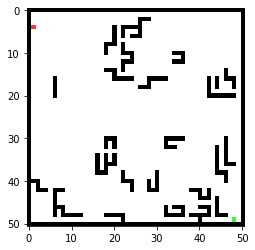

In [ ]:


env = gym.make(env_id)


obs = env.reset()
screen = env.render(mode = 'rgb_array', max_width = 51)
plt.imshow(screen)

##solve with djiskstra

In [ ]:
from google.colab import files

In [ ]:
impassable_array = env.unwrapped.maze.to_impassable()
motions = env.unwrapped.motions
start = env.unwrapped.maze.objects.agent.positions[0]
goal = env.unwrapped.maze.objects.goal.positions[0]
actions = dijkstra_solver(impassable_array, motions, start, goal)
print(actions)
#env = gym.wrappers.Monitor(env, './', force=True)
rewards = 0.0
env.reset()
for action in actions:
    _, reward, _, _ = env.step(action)
    rewards += reward
env.close()
print(rewards)

[3, 3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 1, 3, 3, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3]
0.08999999999999941


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
images = []
obs = env.reset()
#img = model.env.render(mode='rgb_array')
for action in actions:
    #images.append(img)
    #action, _ = model.predict(obs)
    obs, _, done,_ = env.step(action)
    img = env.render(mode='rgb_array', max_width = 51)
    images.append(img)

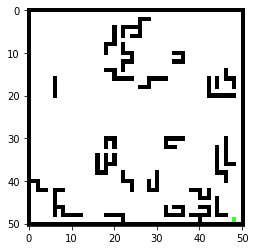

In [ ]:
for i in range(len(images)):
  img = images[i]
  a = plt.imshow(img)
  a.figure.savefig(str(i) + "rl_course_easy_maze_best.png")

In [ ]:
years = list(range(len(images)))
imagesg = list()
for y in years:
    imagesg.append(imageio.imread(str(y) + "rl_course_easy_maze_best.png"))
imageio.mimsave("easy_maze_evolution_best.gif", imagesg,fps = 15)
files.download("easy_maze_evolution_best.gif")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
len(images)

92

In [ ]:
from google.colab import files

In [ ]:
import imageio
imageio.mimsave('maze2d_50by50_v1.gif', [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=10, )
files.download("maze2d_50by50_v1.gif")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## RL BASIC

In [ ]:
import imageio
from google.colab import files

In [ ]:
!apt install swig
!pip install stable-baselines3[extra]

In [ ]:
from stable_baselines3 import A2C, SAC, PPO, TD3, DQN

In [ ]:
# Train the agent
model1 = A2C('MlpPolicy', env, verbose=1).learn(10000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 500       |
|    ep_rew_mean        | -151      |
| time/                 |           |
|    fps                | 414       |
|    iterations         | 100       |
|    time_elapsed       | 1         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -0.889    |
|    explained_variance | -0.000204 |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -3.73     |
|    value_loss         | 7.37      |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 500      |
|    ep_rew_mean        | -87.2    |
| time/                 |          |
|    fps                | 430      |
|    iterations         | 200      |
|

In [ ]:
model2 = PPO('MlpPolicy', env, verbose=1).learn(100000)

In [ ]:
model3 = DQN('MlpPolicy', env, exploration_fraction = .9,verbose=1).learn(10000)

In [ ]:
model3.learn(50000)

In [ ]:
model1

In [ ]:
model = model2

images = []
obs = model.env.reset()
img = model.env.render(mode='rgb_array')
for i in range(500):
    images.append(img)
    action, _ = model.predict(obs)
    obs, _, done,_ = model.env.step(action)
    img = env.render(mode='rgb_array', max_width = 51)

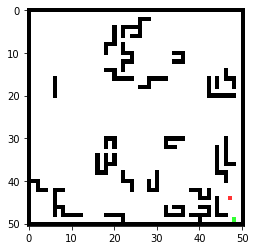

In [ ]:
for i in range(len(images)):
  img = images[i]
  a = plt.imshow(img)
  a.figure.savefig(str(i) + "rl_course_medium_maze_SS.png")

In [ ]:
years = list(range(len(images)))
imagesg = list()
for y in years:
    imagesg.append(imageio.imread(str(y) + "rl_course_medium_maze_PG.png"))
imageio.mimsave("medium_maze_evolution_PG.gif", imagesg,fps = 15)
files.download("medium_maze_evolution_PG.gif")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
years = list(range(len(images)))
imagesg = list()
for y in years:
    imagesg.append(imageio.imread(str(y) + "rl_course_medium_maze_SS.png"))
imageio.mimsave("medium_maze_evolution_SS.gif", imagesg,fps = 15)
files.download("medium_maze_evolution_SS.gif")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#record videos

In [ ]:
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [ ]:
import base64
from pathlib import Path

from IPython import display as ipythondisplay

def show_videos(video_path='', prefix=''):
  """
  Taken from https://github.com/eleurent/highway-env

  :param video_path: (str) Path to the folder containing videos
  :param prefix: (str) Filter the video, showing only the only starting with this prefix
  """
  html = []
  for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
      video_b64 = base64.b64encode(mp4.read_bytes())
      html.append('''<video alt="{}" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>'''.format(mp4, video_b64.decode('ascii')))
  ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

In [ ]:
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

def record_video(env_id, model, video_length=500, prefix='', video_folder='videos/'):
  """
  :param env_id: (str)
  :param model: (RL model)
  :param video_length: (int)
  :param prefix: (str)
  :param video_folder: (str)
  """
  eval_env = DummyVecEnv([lambda: gym.make(env_id)])
  # Start the video at step=0 and record 500 steps
  eval_env = VecVideoRecorder(eval_env, video_folder=video_folder,
                              record_video_trigger=lambda step: step == 0, video_length=video_length,
                              name_prefix=prefix)

  obs = eval_env.reset()
  for _ in range(video_length):
    action, _ = model.predict(obs)
    obs, _, _, _ = eval_env.step(action)

  # Close the video recorder
  eval_env.close()

#visualize

In [ ]:
env_id = 'StupidMaze50by50_easy-v0'
record_video(env_id, model1, video_length=500, prefix='a2c_maze')

Saving video to /content/videos/a2c_maze-step-0-to-step-500.mp4


In [ ]:
show_videos('videos', prefix='a2c_maze')

In [ ]:
env_id = 'StupidMaze50by50_easy-v0'
record_video(env_id, model2, video_length=500, prefix='ppo_maze')

Saving video to /content/videos/ppo_maze-step-0-to-step-500.mp4


In [ ]:
show_videos('videos', prefix='ppo_maze')

In [ ]:
env_id = 'StupidMaze50by50_easy-v0'
record_video(env_id, model3, video_length=500, prefix='dqn_maze')

Saving video to /content/videos/dqn_maze-step-0-to-step-500.mp4


In [ ]:
show_videos('videos', prefix='dqn_maze')

#CMA-ES

In [ ]:
!pip install cma

     |████████████████████████████████| 249 kB 4.1 MB/s 


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
import gym

#old

In [ ]:
import gym
import numpy as np
import cma
from collections import OrderedDict

#from stable_baselines import A2C


def flatten(params):
    """
    :param params: (dict)
    :return: (np.ndarray)
    """
    params_ = []
    for key in params.keys():
        params_.append(params[key].flatten())
    return np.concatenate(params_)

def to_dict(flat_vec, params):
    """
    :param flat_vec: (np.ndarray)
    :param params: (OrderedDict)
    :return: (OrderedDict)
    """
    params_ = OrderedDict()
    start_idx = 0
    for key in params.keys():
        n_elem = params[key].size
        params_[key] = flat_vec[start_idx:start_idx + n_elem].reshape(params[key].shape)
        start_idx += n_elem
    return params_

def filter_policy_params(params):
    """
    Include only variables with "/pi/" (policy) or "/shared" (shared layers)
    in their name: Only these ones affect the action.
    :param params: (OrderedDict)
    :return: (OrderedDict)
    """
    return OrderedDict((key, value) for key, value in params.items()
                        if ("/policy/" in key or "/shared" in key))


def evaluate(env, model):
    """
    Return mean fitness (negative sum of episodic rewards)
    for given model.
    :param env: (gym.Env)
    :param model: (RL Model)
    :return: (float)
    """
    episode_rewards = []
    for _ in range(10):
        reward_sum = 0
        done = False
        obs = env.reset()
        while not done:
            action, _states = model.predict(obs)
            obs, reward, done, info = env.step(action)
            reward_sum += reward
        episode_rewards.append(reward_sum)
    return - np.mean(episode_rewards)

# Create RL model with a small policy network
model = A2C('MlpPolicy', env, ent_coef=0.0, learning_rate=0.1,
            policy_kwargs={'net_arch': [8]}, verbose=0)

#model1 = A2C('MlpPolicy', env, verbose=1).learn(10000)

# Use RL actor-critic policy gradient updates to
# find good initial parameters
model.learn(total_timesteps=5000)

# Get the parameters as the starting point for ES
#model_params = model.get_parameters()


model_params = dict(
    (key, value)
    for key, value in model.policy.state_dict().items()
    if ("policy" in key or "shared_net" in key or "action" in key)
)
# Get only the policy parameters
#policy_params = filter_policy_params(model_params)

policy_params = model_params

# Create the Evolution Strategy (ES) object
es = cma.CMAEvolutionStrategy(flatten(policy_params), sigma0=1)



In [ ]:
for iteration in range(10):
    # Create population of candidates and evaluate them
    candidates, fitnesses = es.ask(), []
    for candidate in candidates:
        # Load new policy parameters to agent.
        #model.policy.load_state_dict(candidate, strict=False)
        model_params = dict(
                    (key, value)
                    for key, value in model.policy.state_dict().items()
                    if ("policy" in key or "shared_net" in key or "action" in key)
                    )
        model.load_parameters(to_dict(candidate, policy_params), exact_match=False)
        # Evaluate the agent using stable-baselines predict function
        fitnesses.append(evaluate(model.get_env(), model))
    # CMA-ES update
    es.tell(candidates, fitnesses)
    # Display some training infos
    mean_fitness = np.mean(sorted(fitnesses)[:int(0.1 * len(candidates))])
    print("Iteration {:<3} Mean top 10% reward: {:.2f}".format(iteration, -mean_fitness))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1429: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif strict and (extra_state_key in state_dict):


AttributeError: ignored

In [ ]:
model = A2C('MlpPolicy', env, ent_coef=0.0, learning_rate=0.1,
            policy_kwargs={'net_arch': [8]}, verbose=0)

#model1 = A2C('MlpPolicy', env, verbose=1).learn(10000)

# Use RL actor-critic policy gradient updates to
# find good initial parameters
model.learn(total_timesteps=5000)

# Get the parameters as the starting point for ES
model_params = model.get_parameters()

# Get only the policy parameters
policy_params = filter_policy_params(model_params)


In [ ]:
class NeuralNetwork(nn.Module):

    def __init__(self, input_shape, n_actions):
        super(NeuralNetwork, self).__init__()
        self.l1 = nn.Linear(input_shape, 32)
        self.l2 = nn.Linear(32, 32)
        self.lout = nn.Linear(32, n_actions)

    def forward(self, x):
        x = F.relu(self.l1(x.float()))
        x = F.relu(self.l2(x))
        return self.lout(x)

    def get_params(self):
        p = np.empty((0,))
        for n in self.parameters():
            p = np.append(p, n.flatten().cpu().detach().numpy())
        return p

    def set_params(self, x):
        start = 0
        for p in self.parameters():
            e = start + np.prod(p.shape)
            p.data = torch.FloatTensor(x[start:e]).reshape(p.shape)
            start = e

In [ ]:
def evaluate(ann, env, visul=True):
    env.seed(0) # deterministic for demonstration
    obs = env.reset()
    if visul:
        img = plt.imshow(env.render(mode='rgb_array'))
    total_reward = 0
    while True:
        # Output of the neural net
        net_output = ann(torch.tensor(obs))
        # the action is the value clipped returned by the nn
        action = net_output.data.cpu().numpy().argmax()
        obs, reward, done, _ = env.step(action)
        total_reward += reward
        if visul:
            img.set_data(env.render(mode='rgb_array'))
            plt.axis('off')
            display.display(plt.gcf())
            display.clear_output(wait=True)
        if done:
            break
    return total_reward

In [ ]:
def fitness(x, ann, env, visul=False):
    ann.set_params(x)
    return -evaluate(ann, env, visul=visul)

In [ ]:
ann = NeuralNetwork(env.observation_space.shape[0], env.action_space.n)

In [ ]:
mean_params = dict(
    (key, value)
    for key, value in model.policy.state_dict().items()
    if ("policy" in key or "shared_net" in key or "action" in key)
)

In [ ]:
net_output.shape

torch.Size([51, 4])

In [ ]:
action = net_output.data.cpu().numpy().argmax()

In [ ]:
action

In [ ]:
env.observation_space

In [ ]:
!pip3 install box2d-py

In [ ]:
import gym
env = gym.make(env_id)
ann = NeuralNetwork(env.observation_space.shape[0], env.action_space.n)

In [ ]:
import cma
ann = NeuralNetwork(env.observation_space.shape[0], env.action_space.n)
es = cma.CMAEvolutionStrategy(len(ann.get_params()) * [0], 0.1, {'seed': 123})

(13_w,27)-aCMA-ES (mu_w=7.8,w_1=22%) in dimension 2852 (seed=123, Mon May 23 13:33:06 2022)


In [ ]:
p = ann.get_params()
np.shape(p)

(2852,)

In [ ]:
p

In [ ]:
env.motions

VonNeumannMotion(north=[-1, 0], south=[1, 0], west=[0, -1], east=[0, 1])

In [ ]:
len(env.motions)

In [ ]:
fitness(x, ann, env, visul=False)

In [ ]:
evaluate(ann, env, visul=False)

In [ ]:
env.observation_space

In [ ]:
mean_params = model1.get_parameters()

In [ ]:
mean_params = dict((key, value) for key, value in mean_params.items()
                   if ("/pi/" in key or "/shared" in key))

In [ ]:
y = np.random.randn(len(ann.get_params()))

In [ ]:
for i in range(20):
    solutions = np.array(es.ask())
    fits = [fitness(y, ann, env) for y in solutions]
    es.tell(solutions, fits)
    es.disp()